#  Installing Required NLP and ML Libraries


In [ ]:
! pip install pyspellchecker deep_translator langdetect spacy tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=c76e7d464265aab533fc2b5db71cd6f9a76458f89c75b4a516351a236580e6a7
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy
from spellchecker import SpellChecker
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score
from deep_translator import GoogleTranslator
from langdetect import detect
import csv
from datetime import datetime

#  Load FAQs Dataset

In [5]:
df_FAQs = pd.read_csv(r"/content/FAQs_data.csv")
df_FAQs

,question,intent
0,What are the advantages of studying at Yarmouk...,university_advantages
1,Why is studying at Yarmouk University beneficial?,university_advantages
2,What makes Yarmouk University a good choice fo...,university_advantages
3,What are the benefits of pursuing studies at Y...,university_advantages
4,Why should I choose Yarmouk University?,university_advantages
...,...,...
4912,Show me the academic profile of Shatha Shakhta...,Ms. SHATHA SHAKHATREH
4913,List the professional details of Shatha Shakht...,Ms. SHATHA SHAKHATREH
4914,How can I contact Shatha Shakhtareh?,Ms. SHATHA SHAKHATREH
4915,What is the email and office location of Shath...,Ms. SHATHA SHAKHATREH


# 📐 Check the Shape of the FAQs DataFrame

In [6]:
print(f"Dataset contains {df_FAQs.shape[0]} rows and {df_FAQs.shape[1]} columns.")

Dataset contains 4917 rows and 2 columns.


# Extracting Questions and Intents from the DataFrame

In [7]:
# Extract question and intent columns
questions = df_FAQs['question']
intents = df_FAQs['intent']

# Display 5 random sample questions
print(questions.sample(5))

# Display 5 random sample intents
print(intents.sample(5))

4363    What is the email and office location of Qasem...
3880    Show me the academic profile of Muhammad Al Za...
66      Are there any student-friendly accommodations ...
4418                    How can I contact Mohammad Akour?
1489                Are diploma courses available online?
Name: question, dtype: object
700         Mr. ABDALLAH AL AKHRAS
1887    suggestions_and_complaints
4069            Dr. AHMAD MANASRAH
1544     strategic_plan_management
3991          Prof. IYAD ABU DOUSH
Name: intent, dtype: object


# 🛠️ Import and Download NLTK Resources for Text Preprocessing


In [8]:
# Download NLTK resources
nltk.download('stopwords')                      # Stop word lists
nltk.download('punkt_tab')                          # Tokenizer
nltk.download('averaged_perceptron_tagger_eng')     # Part-of-speech tagger
nltk.download('wordnet')                    # Lexical database for lemmatization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# 🧹 Full Preprocessing Pipeline for Questions


In [10]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Initialize spell checker
spell = SpellChecker()

# Set of known names and titles to avoid false corrections
set_of_names = {
    'yarmouk', 'hebah', 'manasrah', 'taani', 'zamil', 'radaideh', 'alquran', 'al', 'raoof', "zu'bi", 'sawsan',
    'abuata', 'el', 'ameera', 'rasool', 'noor', 'yousra', 'ahmad', 'saba', 'alsobeh', 'mohawesh', 'wedyan',
    'abdallah', 'abualbasal', 'aleroud', 'khalid', 'aladeen', 'maryam', 'shakhatreh', 'doush', 'alshawakfa',
    'tariq', 'zeyad', 'barhoush', 'akour', 'shehabat', 'smadi', 'issa', 'daradkeh', 'mustafah', 'nahar',
    'jaafrah', 'rami', 'abrar', 'nahlah', 'nuser', 'magableh', 'zahrawi', 'alguni', 'abed', 'alshboul', 'yanal',
    'hamdan', 'qusay', 'qasem', 'radwan', 'elbashabsheh', 'shannaq', 'sukhni', 'akhras', 'bilal',
    "ra'ed", 'mohammed', 'enas', 'hailat', 'alkhushayni', 'dwairi', 'alsrehin', 'naser', 'ali', 'jaradat',
    'alazzam', 'bsoul', 'faisal', 'hammad', 'malek', 'alhaq', 'klaib', 'alawad', 'sami', 'samarah', 'samer',
    'malkawi', 'hasan', 'mohammad', 'alahmad', 'adnan', 'khatib', 'nawaf', "moy'awiah", 'aldeen', 'maghayreh',
    'wejdan', 'shatnawi', 'abu', 'ottom', 'alikhashashneh', 'rafat', 'iyad', 'amani', 'alkhateeb', 'anas',
    'ashraf', 'eslam', 'alshattnawi', 'yazan', 'yousef', 'alshorman', 'hmoud', 'basima', 'alabed', 'suboh',
    'saifan', 'amal', 'aws', 'rawashdeh', 'emad', 'emran', 'harb', 'shatha',
    'dr.', 'prof.', 'ms.', 'mr.','cs','da','cis','bit','cys',  # Titles
}

def correct_spelling(text):
    """
    Corrects misspellings in text, ignoring known names and titles.
    """
    words = text.split()
    corrected_words = [
        word if word.lower() in set_of_names or word.istitle()
        else spell.correction(word) or word
        for word in words
    ]
    return ' '.join(corrected_words)

def get_wordnet_pos(tag):
    """
    Maps POS tag to WordNet POS tag for lemmatization.
    """
    if tag.startswith('V'):
        return 'v'
    elif tag.startswith('N'):
        return 'n'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'  # Default to noun

def preprocess_question(question):
    """
    Preprocess a single question: lowercase, tokenize, remove stopwords,
    lemmatize using POS tagging, and return cleaned tokens.
    """
    preserve_words = {"cs", "ai", "it","da","cis","cys","bit"}
    question = question.lower()
    question = re.sub(r'(?<=\w)\.(?=\w)', '. ', question)  # Fix punctuation without space #
    tokens = word_tokenize(question)
    tokens = [t for t in tokens if t not in string.punctuation and t not in stop_words]
    tagged_tokens = nltk.pos_tag(tokens)
    tokens = [
    t[0] if t[0] in preserve_words else lemmatizer.lemmatize(t[0], get_wordnet_pos(t[1]))
    for t in tagged_tokens
]
    tokens = [t for t in tokens if t.strip()]
    return tokens

# Preprocess all questions
processed_questions = [preprocess_question(q) for q in questions]
processed_questions = [' '.join(q) for q in processed_questions]

# Show a preview of processed results
print("First 5 processed questions:", processed_questions[2030:2105])

First 5 processed questions: ['find 2024 study plan computer science', 'program description computer science', 'tell computer science cs curriculum change', 'computer science cs program prepare graduate job market', 'give url latest computer science cs study plan', 'skill teach computer science cs program', 'show study plan computer information system cis program', 'list detail computer information system cis bachelor ’ program', 'provide information computer information system cis curriculum', 'need detail computer information system cis program update', 'find 2024 study plan computer information system', 'program description computer information system', 'tell computer information system cis curriculum change', 'computer information system cis program prepare graduate job market', 'give url latest computer information system cis study plan', 'skill teach computer information system cis program', 'show study plan business information technology bit program', 'list detail business info

#🔍 Name Matching and Correction Module
- This Python module implements a simple name matching and correction system. It is designed to:

- Extract potential name parts from a user's query, including names following titles (e.g., "Dr.", "Professor") and possessive forms (e.g., "Ali’s").

- Correct name misspellings by comparing extracted name parts to a predefined list of names using the Levenshtein distance algorithm.

- Return a rewritten version of the query with corrected names while preserving the original structure as much as possible.

In [ ]:
class NameMatcher:
    def __init__(self, names_list):
        self.names_list = names_list

    def extract_name_parts(self, query):
        """Extract all name-like parts including possessives and after titles/indicators"""
        titles = ['dr', 'dr.', 'doctor', 'prof', 'prof.', 'professor', 'mr', 'mr.', 'mrs', 'mrs.', 'ms', 'ms.']
        indicators = ['of', 'for', 'about']
        words = query.lower().split()
        name_parts = set()

        for i in range(len(words) - 1):
            if words[i] in titles or words[i] in indicators:
                # Collect next 2 words assuming full name is two words
                next_parts = words[i + 1:i + 3]
                for part in next_parts:
                    if part.isalpha():
                        name_parts.add(part)

        # Handle possessive forms like "soboh's"
        for word in words:
            if word.endswith("'s") or word.endswith("’s"):
                base = word[:-2]
                if base.isalpha():
                    name_parts.add(base)

        return list(name_parts)

    def levenshtein_distance(self, str1, str2):
        """Calculate Levenshtein distance between two strings"""
        m, n = len(str1), len(str2)
        dp = [[0] * (n + 1) for _ in range(m + 1)]

        for i in range(m + 1):
            dp[i][0] = i
        for j in range(n + 1):
            dp[0][j] = j

        for i in range(1, m + 1):
            for j in range(1, n + 1):
                cost = 0 if str1[i - 1] == str2[j - 1] else 1
                dp[i][j] = min(dp[i - 1][j] + 1,     # deletion
                               dp[i][j - 1] + 1,     # insertion
                               dp[i - 1][j - 1] + cost)  # substitution
        return dp[m][n]

    def find_best_match(self, word):
        """Find closest match for a single word"""
        if not word:
            return None

        min_distance = float('inf')
        best_match = None
        for name in self.names_list:
            for part in name.lower().split():
                distance = self.levenshtein_distance(word, part)
                if distance < min_distance:
                    min_distance = distance
                    best_match = part

        threshold = len(word) // 3
        return best_match if min_distance <= threshold else None

    def process(self, query):
        """Process the query and return corrected version"""
        name_parts = self.extract_name_parts(query)
        corrections = {}

        for part in name_parts:
            match = self.find_best_match(part)
            if match:
                corrections[part] = match

        rewritten_query = query.lower()
        for wrong, correct in corrections.items():
            rewritten_query = rewritten_query.replace(wrong, correct)

        return {
            "original_query": query,
            "extracted_names": name_parts,
            "corrections": corrections,
            "rewritten_query": rewritten_query
        }


def demonstrate_name_matcher(q):
    q= re.sub(r'(?<=\w)\.(?=\w)', '. ', q)  # Fix punctuation without space #
    q= re.sub(r'(?<=\w)\?', ' ? ', q)
    q= re.sub(r'(?<=\w)\!', ' ! ', q)
    q= re.sub(r'(?<=\w)\-', ' - ', q)
    predefined_names = set_of_names
    matcher = NameMatcher(predefined_names)

    result = matcher.process(q)

    print(f"Original: {result['original_query']}")
    print(f"Extracted: {result['extracted_names']}")
    print(f"Corrections: {result['corrections']}")
    print(f"Rewritten: {result['rewritten_query']}")

    print("-" * 40)

    return result['rewritten_query']

# Encoding Target Labels (Intents)

This cell uses `LabelEncoder` from Scikit-learn to convert the categorical intent labels into numeric values. This transformation is necessary for training most machine learning models, which require numerical input.


In [ ]:
# Initialize the label encoder
encoder = LabelEncoder()

# Encode the intent labels into numeric form
y = encoder.fit_transform(intents)

# Splitting Data into Training and Testing Sets

This cell splits the TF-IDF features (`X`) and encoded labels (`y`) into training and testing sets using an 80/20 ratio. A fixed `random_state` ensures reproducibility of results. The testing set (`X_test`, `y_test`) will be used later to evaluate model performance.


In [ ]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train_texts, X_test_texts, y_train, y_test = train_test_split(processed_questions, y, test_size=0.2, random_state=42)

# Now, we have X_test and y_test to evaluate the model

# TF-IDF Vectorization of Preprocessed Questions

This cell uses `TfidfVectorizer` from Scikit-learn to convert the list of preprocessed text questions into numerical feature vectors. The TF-IDF (Term Frequency–Inverse Document Frequency) technique helps in understanding the importance of each word in a document relative to the entire corpus.


In [ ]:
# 2. Create the vectorizer and fit on training texts only
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train_texts).toarray()

# 3. Transform test texts using the same vectorizer
X_test = vectorizer.transform(X_test_texts).toarray()

# Building and Training a Neural Network Classifier with Early Stopping

This cell builds a simple feedforward neural network using TensorFlow/Keras for multi-class classification. The model has two hidden layers with dropout regularization to prevent overfitting. The output layer uses a `softmax` activation to predict the intent class.

- **Loss Function:** `sparse_categorical_crossentropy` (for integer-encoded labels)
- **Optimizer:** `adam`
- **Metric:** `accuracy`
- **Callback:** `EarlyStopping` is used to halt training when validation loss stops improving for 10 consecutive epochs, and restores the best model weights.


In [ ]:
    # Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Define the neural network model
model1 = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(len(set(intents)), activation='softmax')  # Output layer for classification
])

# Compile the model
model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model with EarlyStopping
history=model1.fit(
    X_train, y_train,
    epochs=100,
    batch_size=10,
    validation_split=0.2,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0181 - loss: 5.4201 - val_accuracy: 0.0178 - val_loss: 4.9500
Epoch 2/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0805 - loss: 4.6552 - val_accuracy: 0.3825 - val_loss: 3.7616
Epoch 3/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3376 - loss: 3.3959 - val_accuracy: 0.6557 - val_loss: 2.3986
Epoch 4/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5324 - loss: 2.3095 - val_accuracy: 0.7751 - val_loss: 1.5349
Epoch 5/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6230 - loss: 1.7484 - val_accuracy: 0.8247 - val_loss: 1.0825
Epoch 6/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7095 - loss: 1.2930 - val_accuracy: 0.8501 - val_loss: 0.8183
Epoch 7/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7739 - loss: 0.9920 - val_accuracy: 0.8640 - val_loss: 0.6616
Epoch 8/100
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8074 - loss: 0.8321 - val_acc

### Saving the Trained Model

This cell saves the trained neural network model to a file named `FNN_model.keras`. This allows you to load the model later without retraining it.


In [ ]:
# Save the trained model to a file
model1.save('FNN_model.keras')

### Loading the Saved Model

This cell loads the previously saved neural network model (`FNN_model.keras`) using Keras' `load_model` function. This allows for making predictions or further evaluation without retraining the model.


In [ ]:
# Load the saved model from file
model1 = load_model(r'/content/FNN_model.keras')

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       158,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 236)            │        15,340 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 547,718 (2.09 MB)

 Trainable params: 182,572 (713.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 365,146 (1.39 MB)

### Evaluating the Model on the Test Set

This cell evaluates the performance of the trained model on the unseen test set. It reports both the **accuracy** and the **loss**, which help assess how well the model generalizes to new data.


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model1.evaluate(X_test, y_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9054 - loss: 0.2697


In [ ]:
# Step 1: Get predicted probabilities from the model
y_probs = model1.predict(X_test)

# Step 2: Convert probabilities to predicted class labels
y_pred = np.argmax(y_probs, axis=1)

# Step 3: Compute average Precision, Recall, and F1-score
avg_precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
avg_recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
avg_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
# Create a dictionary of metrics
metrics = {
    'Metric': ['Test Accuracy', 'Test Loss', 'Precision', 'Recall', 'F1-score'],
    'Score': [test_accuracy, test_loss, avg_precision, avg_recall, avg_f1]
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
(metrics_df)

,Metric,Score
0,Test Accuracy,0.903455
1,Test Loss,0.291049
2,Precision,0.879491
3,Recall,0.878648
4,F1-score,0.867552


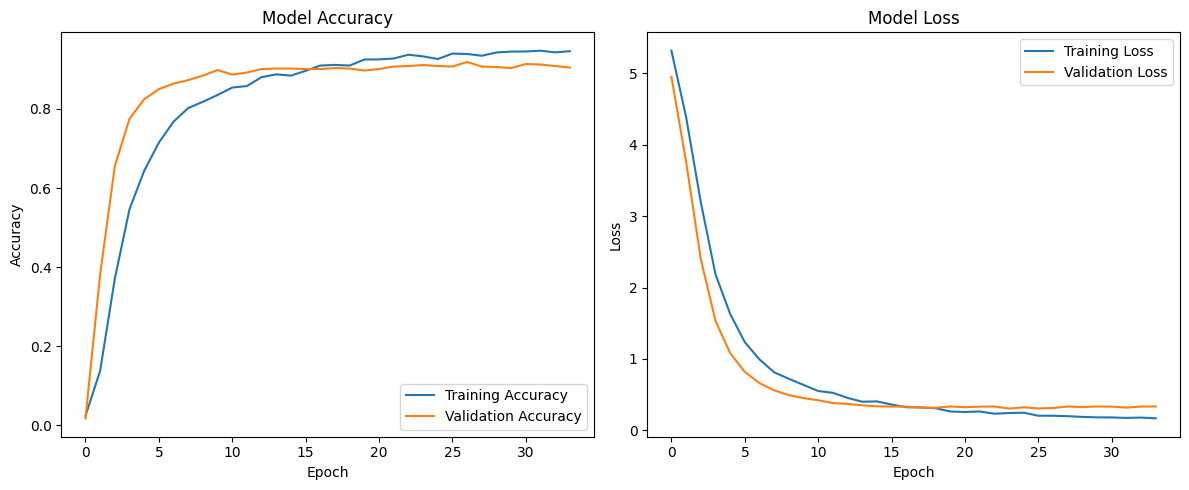

In [ ]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

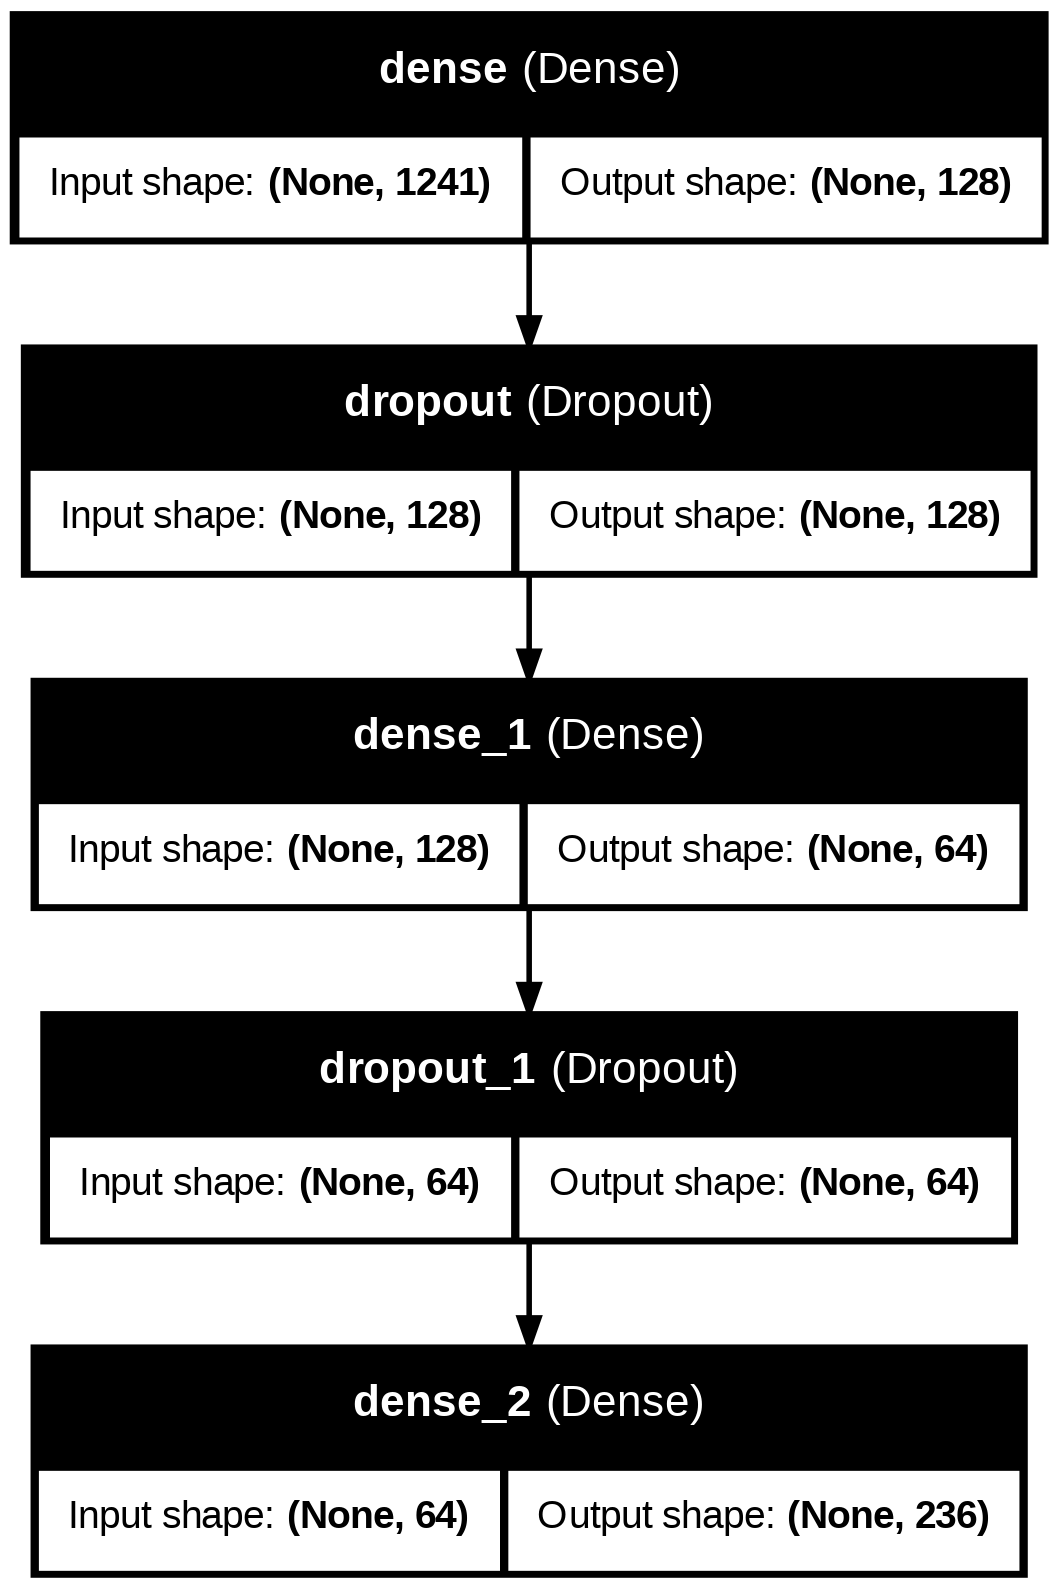

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)

# Loading and Previewing the Response Data

This cell performs the following actions:
- Loads response data from a CSV file (`response_data.csv`) into a pandas DataFrame.
- Displays a random sample of 5 rows from the DataFrame to preview the contents.


In [ ]:
# Create a DataFrame
df_R = pd.read_csv(r"/content/response_data.csv")

df_R.sample(5)

,Intent,answer
69,Mr. ABDALLAH AL AKHRAS,Name: Mr. ABDALLAH AL AKHRAS \nEmail: abdalla_...
33,Prof. KHALID NAHAR,Name: Prof. KHALID NAHAR \nEmail: khalids@yu.e...
80,Dr. ALI ZAHRAWI,Name: Dr. ALI ZAHRAWI \nEmail: ali.z@yu.edu.jo...
20,university_website,The official website of Yarmouk University can...
152,abhath_al_yarmouk,The link of Abhath Al-Yarmouk is https://gradu...


### Checking the Shape of the Response DataFrame



In [ ]:
print(f"Dataset contains {df_R.shape[0]} rows and {df_R.shape[1]} columns.")

Dataset contains 236 rows and 2 columns.


# Multilingual User Input Processing

This cell processes user input in any language, detects its language, translates it to English if needed, and then retrieves a response from the chatbot. The process involves the following steps:
1. **Language Detection:** Detects the language of the user input using `langdetect`.
2. **Translation (if necessary):** If the input is in Arabic, it is translated to English using `GoogleTranslator`.
3. **Response Retrieval:** The translated input is passed to the chatbot system to generate an appropriate response.

The function handles Arabic and English inputs but can be extended for more languages.


In [ ]:
def translate_text(text, src_lang, dest_lang):
    """Translate text from src_lang to dest_lang using GoogleTranslator."""
    return GoogleTranslator(source=src_lang, target=dest_lang).translate(text)

def process_user_input(user_input):
    """Detect language, translate if needed, get chatbot response, and translate back if required."""

    # Step 1: Detect the language of user input
    user_lang = detect(user_input)

    if user_lang != "en":
        user_lang = 'ar'  # Only Arabic and English supported here

    # Step 2: Translate Arabic input to English
    if user_lang == "ar":
        translated_input = translate_text(user_input, "ar", "en").lower()
    else:
        translated_input = user_input  # No translation needed

    print(f"Translated Input (to English): {translated_input}")  # Debugging step

    # Step 3: Get chatbot response in English
    response, intent = get_response(translated_input, user_lang)
    print(response)

    # Step 4: (Optional) Translate back to Arabic or process response
    generated_response = ask_yu_assistant(user_input, intent, response)

    return generated_response


# Handling User Input and Intent Prediction with Fallback Responses

This function processes the user's input, predicts the intent, and returns an appropriate response. It handles edge cases such as empty input and unknown intents. The process includes the following steps:

1. **Handle Empty Input:** If the user doesn't provide any input, a prompt asking for more information is returned.
2. **Text Preprocessing:** The input is preprocessed by cleaning and tokenizing the text. If the language is English, spelling corrections are applied.
3. **Intent Prediction:** The function predicts the intent based on the processed input.
4. **Fallback for Unknown or Invalid Intent:** If the intent is "unknown" or not found in the data, the function returns a fallback response asking the user to rephrase or provide more details.
5. **Answer Retrieval:** If the intent is valid, it retrieves the corresponding answer from the dataset (`df_R`).

This ensures that the chatbot provides helpful responses even when it doesn’t fully understand the input.


In [ ]:
def get_response(user_input, user_lang):
    # Handle empty input
    if not user_input.strip():
        return "It looks like you didn’t type anything. How can I help you today?", "unknown"

    # Preprocess user input
    processed_text=demonstrate_name_matcher(user_input)
    processed_text = preprocess_question(processed_text)  # Text preprocessing
    processed_text = ' '.join(processed_text)
    if user_lang == 'en':
        processed_text = correct_spelling(processed_text)  # Spell checking

    print(processed_text)

    # Predict intent using the processed text
    predicted_intent = predict_intent(processed_text,user_input)

    # If intent is "unknown" or not found in data, return fallback response
    if predicted_intent == "unknown" or predicted_intent not in df_R['Intent'].values:
        return "I'm not sure I understand your question. Could you please rephrase it or provide more details?", "unknown"

    # Get the answer for the predicted intent
    intent_row = df_R[df_R['Intent'] == predicted_intent]
    return intent_row.iloc[0]['answer'], predicted_intent


# Predicting User Intent from Input Text

This function takes a user's input string and predicts the corresponding intent using the trained model. It performs the following steps:

- Vectorizes the input using the same TF-IDF vectorizer used during training.
- Predicts intent probabilities with the trained model.
- Applies a confidence threshold (0.5); if no intent exceeds it, returns `"unknown"`.
- Decodes the predicted label back to its original intent name using `LabelEncoder`.
- saving the unkown intent to the log file


In [ ]:
def predict_intent(user_input,original):

    # Vectorize the input
    input_vector = vectorizer.transform([user_input]).toarray()

    # Predict class probabilities
    predicted_probabilities = model1.predict(input_vector)[0]

    # Check confidence threshold
    if max(predicted_probabilities) < 0.5:

            log_path = r"/content/unknown_predictions_log.csv"
            with open(log_path, mode='a', newline='', encoding='utf-8') as log_file:
                writer = csv.writer(log_file)
                writer.writerow([
                    datetime.now().strftime("%d-%m-%Y"),
                    original,
                    user_input
                ])

            return "unknown"

    # Get predicted class and decode to intent label
    predicted_class = predicted_probabilities.argmax()
    predicted_intent = encoder.inverse_transform([predicted_class])

    return predicted_intent[0]

# Yarmouk University Assistant - API Integration

This function sends user queries to the OpenRouter API and returns a response, depending on whether the intent is recognized or not. The process involves interacting with the API and using a system prompt to provide context-specific answers. Here’s the step-by-step breakdown:

1. **System Prompt for Recognized Intent:**
    - If the user input matches a recognized intent (i.e., it's not "unknown"), the function creates a system prompt asking the assistant to answer using the provided information (`fixed_response`).
    - The assistant is instructed to answer clearly, concisely, and professionally, using only the provided information.

2. **System Prompt for Unrecognized Intent:**
    - If the intent is "unknown," the assistant is asked to respond naturally and helpfully, without providing any information beyond what is known about Yarmouk University.
    - If the question is not related to the university, the assistant says it doesn't know the answer.

3. **Making the API Call:**
    - The function sends a request to the OpenRouter API, including the system prompt and the user's input, and retrieves a response using the `NVIDIA: Llama 3.1 Nemotron Ultra 253B v1 (free)` model.

4. **Processing the API Response:**
    - The API response is checked for errors (e.g., status code 200 indicates success).
    - If the response contains an email, the function replaces the email format (`**email@example.com**`) with a simpler version (`(email@example.com)`).

5. **Returning the Response:**
    - The assistant returns the generated response to the user, or an error message if the API call fails.

This function integrates the chatbot with external resources, allowing it to provide contextually relevant responses based on the user input.


In [ ]:
import requests
import json

# 🔐 API Key من OpenRouter
api_key = "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"

def ask_yu_assistant(user_input: str, intent: str, fixed_response: str = None) -> str:
    # إذا في معلومات ثابتة (intent معروف)
    if intent != 'unknown':
        system_prompt = """
You are a helpful assistant for Yarmouk University.
Your job is to answer ONLY using the provided information.
Do not guess or add anything extra. Be clear, concise, and professional.
Always respond in the language used by the User's question."""
        messages = [
            {"role": "system", "content": system_prompt},
            {
                "role": "user",
                "content": f"""
User's question:
{user_input}

Available information:
\"\"\"
{fixed_response}
\"\"\""""
            }
        ]
    else:
        # إذا ما في معلومات (intent غير معروف)
        system_prompt = """
You are a helpful assistant for Yarmouk University.
The user is asking a general question. Answer naturally and helpfully.
If the quesion not about the Yarmouk University don't answer and say somthing that you don't know.
Always respond in the language used by the User's question.
"""
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_input}
        ]

    # 🚀 تنفيذ الطلب إلى OpenRouter
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {api_key}",
            "Content-Type": "application/json",
            # "HTTP-Referer": "https://yourdomain.com",  # اختياري
            # "X-Title": "Yarmouk Assistant Bot",        # اختياري
        },
        data=json.dumps({
            "model": "deepseek/deepseek-chat-v3-0324:free",
            "messages": messages
        })
    )

    # 🧠 استرجاع الجواب أو الخطأ
    if response.status_code == 200:
        reply = response.json()["choices"][0]["message"]["content"]

        # Replace emails in **email** format to (email)
        cleaned_text = re.sub(r'\*+([a-zA-Z0-9@._-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})\*+', r'\1', reply)
        cleaned_text = re.sub(r'\*+(https?://[^\s\*]+)\*+', r'\1', cleaned_text)
        cleaned_text = re.sub(r'[\[\]()]+\s*(https?://[^\s\[\]()]+)\s*[\[\]()]+', r'\1', cleaned_text)
        cleaned_text = re.sub(r'\*+([a-zA-Z0-9._-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,})\*+', r'\1', cleaned_text)
        return cleaned_text


        return reply

    else:
        return f"❌ Error {response.status_code}: {response.text}"

# Interactive Chatbot Loop

This section of the code enables the chatbot to interact with the user in a continuous loop. The user can type questions, and the chatbot will respond accordingly. Here's how it works:

1. **Continuous Input Prompt:**
    - The program enters a `while True` loop that keeps asking the user for input until they decide to exit.
  
2. **Handling Empty Input:**
    - If the user doesn’t type anything (empty input), the chatbot prompts them to type something to ask.
  
3. **Exit Condition:**
    - If the user types "exit" (case-insensitive), the loop breaks, and the chatbot says goodbye.

4. **Processing User Input:**
    - The `process_user_input()` function is called to process the user's input, translate if needed, and provide a response. The chatbot then prints the response.

This interactive loop ensures that the chatbot stays active and responsive until the user decides to end the conversation by typing "exit".


In [ ]:
while True:
    user_input = input("You: ").strip()

    # Handle empty input
    if not user_input:
        print("Bot: Please type something to ask.")
        continue

    # Exit condition
    if user_input.lower() == "exit":
        print("Bot: Goodbye!")
        break

    # Process the user's input and get the response
    print("Bot:", process_user_input(user_input))

You: what the email of dr enas?
Translated Input (to English): what the email of dr enas?
Original: what the email of dr enas ? 
Extracted: ['enas', 'dr']
Corrections: {'enas': 'enas'}
Rewritten: what the email of dr enas ? 
----------------------------------------
email dr enas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Name: Dr. ENAS ALIKHASHASHNEH 
Email: enas.a@yu.edu.jo 
Office location: مبنى الخوارزمي / الطابق الثالث / رقم المكتب 312 
Full profile: https://fmd.yu.edu.jo/AcademicsCard.aspx?Card=dtVpjwMiCu8=
Bot: 
You: what the email of dr enas ?
Translated Input (to English): what the email of dr enas ?
Original: what the email of dr enas ?
Extracted: ['enas', 'dr']
Corrections: {'enas': 'enas'}
Rewritten: what the email of dr enas ?
----------------------------------------
email dr enas
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Name: Dr. ENAS ALIKHASHASHNEH 
Email: enas.a@yu.edu.jo 
Office location: مبنى الخوارزمي / الطابق الثالث / رقم المكتب 312 
Full profile: https://fmd.yu.edu.jo/Acad

# Yarmouk University Telegram Assistant Bot

In [ ]:
! pip install python-telegram-bot==20.7

In [ ]:
from telegram import Update
from telegram.ext import ApplicationBuilder, CommandHandler, MessageHandler, filters, ContextTypes
import asyncio

bot_token = '7741799690:AAHvMyriTfBCQjHRj-F1z5_cqxHLZeyNbRQ'

async def start(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    await update.message.reply_text('Hello! I am your Yarmouk Assistant bot. Ask me anything about Yarmouk University.')

async def help(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    await update.message.reply_text("Feel free to ask any questions related to Yarmouk University. I'm here to assist you!")

async def handle_message(update: Update, context: ContextTypes.DEFAULT_TYPE) -> None:
    user_input = update.message.text.lower()  # Convert to lowercase to handle 'Exit' or 'exit'

    # Show typing indicator while processing
    await update.message.chat.send_action(action="typing")

    # Process the message and get response
    intent = process_user_input(user_input)

    # Send the response
    await update.message.reply_text(intent)

# Main function to run the bot
async def main():
    application = ApplicationBuilder().token(bot_token).build()

    application.add_handler(CommandHandler('start', start))
    application.add_handler(CommandHandler('help', help))
    application.add_handler(MessageHandler(filters.TEXT & ~filters.COMMAND, handle_message))

    print("Bot is running...")

    # Run the bot with polling, which will stop when stop() is called
    await application.run_polling()

# Run the bot
import nest_asyncio
nest_asyncio.apply()

# Run the bot asynchronously
await main()